# LSTM using TimeGenerator 

A more meaningful and complete example is given below that can be used as a black-box. Here we give multivariate, single step prediction with various look ahead

In [6]:
import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from IPython import display
from keras.preprocessing.sequence import TimeseriesGenerator
import IPython
from IPython.display import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)


In [7]:
# Read Data
#del dfn1
if ( "dfn1" not in globals()):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path, nrows=100000)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn
    
dfn2

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
2009-01-01 00:30:00,-8.51,996.53,1310.24
2009-01-01 00:40:00,-8.31,996.51,1309.19
2009-01-01 00:50:00,-8.27,996.51,1309.00
...,...,...,...
2010-11-25 10:20:00,-0.30,977.96,1245.92
2010-11-25 10:30:00,0.50,977.94,1242.25
2010-11-25 10:40:00,0.95,977.88,1240.10


# Data

Review the data carefully. It has 100k rows, readings taken for every 10 minutes; we chose 3 features (it can be one). We want to look back 720 readings back (in a day we have 24 * 6 = 144 readings, we sample every 6th, reading, therefore, we must have 120 time-steps x 3 features) and predict the temperature one hour ahead i.e. 10 readings ahead) 

Notice we carefully chose one hour ahead prediction because, it aligns well with sampling_rate of 6.
If we wanted to predict two hours ahead, we cannot use sampling_rate, because it affects both X and y. 
In this case we must adjust labels correctly.

Similarly if we wanted multistep, then we must prepare y appropriately.

In [76]:
''' This just builds a model 
Optimizeers
opt1 = tf.keras.optimizers.RMSprop(clipvalue=1.0)
 
 inshape = input shape => #time_steps x #features
'''
import keras

def lstmmodel(inps, inshape, units2=None, nsteps=1, opt="adam", loss="mse", bi=False, dropout=None):
    s= inshape
    print(locals())
    print(f"Creating LSTM: inuts= {inps} time-steps: {s[0]}, features: {s[1]} #out: {nsteps}")
    m = keras.models.Sequential()

    if (bi):
        m.add(keras.layers.Bidirectional(
            keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) ) )
    else:
        m.add(keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) )
    
    if(units2 is not None): #Lets just keep it simple for 2 layers only
        m.add(keras.layers.LSTM(units2, activation='relu'))
    if (dropout is not None):
        m.add( keras.layers.Dropout(dropout) )
    m.add(keras.layers.Dense(nsteps))
    m.compile(optimizer = opt, loss= loss)
    return m
 
def makestep(a, start, steps=5):
    o= []
    for i in range(steps):
        a1 = a[start+i:-steps+i+1 or None]
        o.append(a1)
    
    return np.hstack([o]).T

def Plot_(y, h, x=None, title=None,**kwargs):
    #x = x if x is not None else range(len(y))
    plt.plot(y[:,0], marker=".", label = "y")

    if ( len(h.shape) <= 1):
        h = h.reshape((len(h), 1))
    for i in range(h.shape[-1]):
        uy=h[i:,i]
        plt.plot(range(i, len(uy)+i), uy, marker="x",  label = f"$h_{i}$")

    plt.title(title)
    plt.grid(b="on")
    plt.legend()
    return y1, h1;

def modelEqual(m1, m2):
    ok = len(m1.layers) ==  len(m2.layers)
    if (not ok):
        return ok

    for l1, l2 in zip(m1.layers, m.layers):
        c1, c2 = l1.get_config(), l2.get_config()
        tn = c1['name'] 
        c1['name'] = c2['name'] 
        ok = c1 == c2 
        c1['name'] = tn
        if (not ok):
            break;
    return ok

class NNmodel:
    def __init__(self, tsParams, model, file=None,  nsteps=1, load=True):
        defp =  { 
                    "length":         20,
                    "batch_size":     256,
                    "stride":         1,
                    "sampling_rate" : 1
                }
        self.model = m
        self.tsParam(tsParams or defp)
        
        if( file is not None):
            self.model_file=file;
            #Load the file and other parameters 
            if (load and os.path.exists(file)):
                m1=self.load()
                if modelEqual(m,m1) or m is None:
                    m.set_weights(m1.get_weights()) 
                    print(f"Using the loaded model {file}!!")
                else:
                    print("Models are different, ignoring model loaded from file")
        
        self.nsteps= nsteps # nstep predictions
    
    def tsParam(self, tsParams = None):
        if (tsParams is not None):
            self.tsParams = tsParams;
            self.setvals(tsParams)
        return self.tsParams;
    
    def setvals(self, d: dict):
        for k, v in d.items():
            setattr(self, k, v)

    def save(self, file = None):
        model_file = file or self.model_file
        self.model.save(model_file)

    def load(self, file = None):
        model_file = file or self.model_file
        m = load_model(model_file)
        return m

    def dump(self):
        vr = vars(nnmodel)
        for k,v in vr.items():
            if type(v) == pd.core.frame.DataFrame:
                print(f'{k}: shape:{v.shape}')
            else:
                print(f'{k}, {type(v)}: {v}')
                
    # First, do preprocessing which consists of:
    # 1. Remove time correlated variables
    # 2. Add a time cycle if it makes sense, Suppose a event occurs based on time, then we must have that cycle
    # 3. Normalize the data

    # *NOTE* we scale only on the training data - *NOT* on the entire dataset
    #
    def prepare(self,dfn2, pct=0.8):
        df = dfn2.copy()

        trni = int(len(df) * pct) if (pct < 1) else pct

        print(f"#Training samples: {trni}")

        scaler = StandardScaler()
        dfs = scaler.fit(df[:trni])
        dfs.mean_, dfs.scale_
        dfns = (df-dfs.mean_)/dfs.scale_

        self.df, self.trn, self.val, self.scaler = dfns, dfns[:trni], dfns[trni:], scaler
        
        return self.df, self.trn, self.val, self.scaler 
    
    #def createModel(self, inps, inshape, units2=None, nstep=1, opt="adam", loss="mse" ):
    #    self.model = lstmmodel(inps, inshape, units2=units2, nstep=nstep, opt="adam", loss="mse" )

    def tsg(self, data: np.ndarray,  scale=False, batch_size=None,lables=None, lableIndex=0):

        lables = lables if lables is not None else data[:,lableIndex]
        
        if (scale):
            data = (data-self.scaler.mean_)/self.scaler.scale_

        tsParams = self.tsParams
        if (batch_size is not None and batch_size != tsParams['batch_size']):
            tsParams = self.tsParams.copy()
            tsParams['batch_size'] = batch_size;
          
        print(tsParams)
        
        lables = makestep(lables, 0, self.nsteps)
        #print(f'==> {lables.shape}, {nsteps}')
        data   = data[:-self.nsteps+1 or None]
        
        tsg    = TimeseriesGenerator(data, lables, **tsParams )
        return tsg
        
    def tsgfit(self, lables=None, lableIndex=0):
        self.trng    = self.tsg( self.trn.values, lables=lables, lableIndex=lableIndex )
        self.valg    = self.tsg( self.val.values, lables=lables, lableIndex=lableIndex  )

        return self.trng, self.valg

    def fit(self,epochs=1, trn=None, val=None):
        if not hasattr( self, "trng"):
            self.tsgfit()
            
        if (trn is None or val is None):
            trn,val = self.trng, self.valg
            
        for i in range(epochs):
            self.model.fit(trn, verbose=1, epochs=1, validation_data=val, steps_per_epoch=200, 
                          validation_steps=50, workers=4, use_multiprocessing=True)
             
    def predict(self, df, start=0, howmany=100, lableIndex=0, scalein=False, scaleout=True, title=""):
        data=df
        scaler = self.scaler
        model = self.model

        if (type(df) == pd.DataFrame):
            data = df.values

        if (scalein):
            data = (data-scaler.mean_)/scaler.scale_

        data   = df[start:].values
        labels = data[:, lableIndex]
        g=self.tsg(data, batch_size=howmany, lableIndex=0)
        x, y = g[0]
        h = model.predict(x)

        h1, y1 = h,y
        if (scaleout):
            h1 = h * scaler.scale_[lableIndex]
            h1 = h1  + scaler.mean_[lableIndex]

            y1 = y * scaler.scale_[lableIndex]
            y1 = y1  + scaler.mean_[lableIndex]

        return y1, h1


{'inps': 32, 'inshape': (20, 1), 'units2': None, 'nsteps': 1, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (20, 1)}
Creating LSTM: inuts= 32 time-steps: 20, features: 1 #out: 1
Using the loaded model m1.h5!!
#Training samples: 80000
{'length': 20, 'batch_size': 100, 'stride': 1, 'sampling_rate': 1}


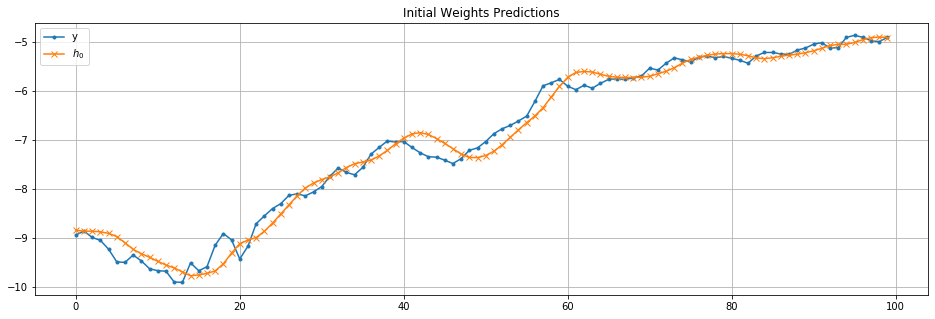

In [66]:
# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         20,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 1
}

m = lstmmodel(32, (20,1), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1 = NNmodel(tsParams=tsParams, model=m, file="m1.h5")
nnmodel1.prepare(dfn1, pct=80000)

y1, h1 = nnmodel1.predict(nnmodel1.df,0, 100)
o= Plot_(y1, h1, title="Initial Weights Predictions")


{'length': 20, 'batch_size': 100, 'stride': 1, 'sampling_rate': 1}


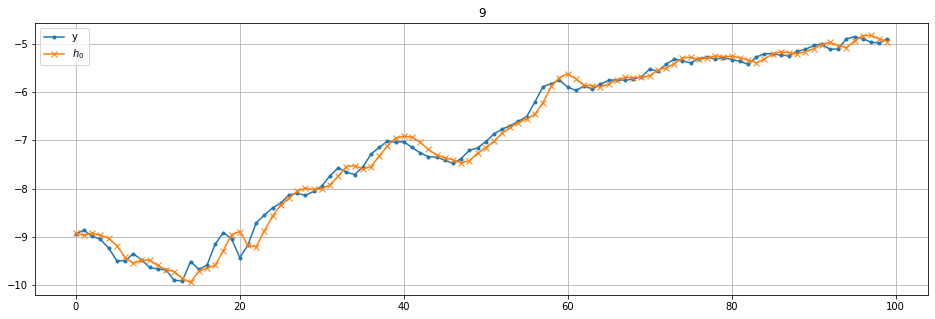

Epoch 1/1
200/200 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 0.0013


In [69]:
epochs=10
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1.predict(nnmodel1.df,0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1.save()

# Sampling Rate and Stride

Just inspect what are the values set 

In [70]:
# Sanity Check to make sure everything is aligned
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}
data   = dfn2.values
labels = data[:,0]
g = TimeseriesGenerator(data, labels, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0][-3:]} <= should match every 6th entry\n Also: \n{y[0]} <= 720th entry')

(256, 120, 3), (256,) -12.78
X: 
[[ -10.32  996.58 1319.77]
 [ -10.74  997.04 1322.53]
 [ -11.96  997.42 1329.27]] <= should match every 6th entry
 Also: 
-12.78 <= 720th entry


In [71]:
# Sanity Check to visually check if X and y correctly aligned
# Whenever you see "<=" mark, it is aligned at sampling rate of 6

dfn3= dfn2.copy()
dfn3['idx'] = [i if i % 6 != 0 else f'<={i}' for i in range(len(dfn3))]
display(dfn3[700:724])
del dfn3

,T (degC),p (mbar),rho (g/m**3),idx
Date Time,,,,
2009-05-01 20:50:00,-10.07,996.23,1318.03,700
2009-05-01 21:00:00,-10.18,996.43,1318.87,701
2009-05-01 21:10:00,-10.32,996.58,1319.77,<=702
2009-05-01 21:20:00,-10.41,996.71,1320.40,703
2009-05-01 21:30:00,-10.44,996.78,1320.66,704
2009-05-01 21:40:00,-10.46,996.87,1320.87,705
2009-05-01 21:50:00,-10.50,996.95,1321.19,706
2009-05-01 22:00:00,-10.60,996.99,1321.75,707
2009-05-01 22:10:00,-10.74,997.04,1322.53,<=708


# Multivariate Predictions

{'inps': 32, 'inshape': (120, 3), 'units2': None, 'nsteps': 1, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (120, 3)}
Creating LSTM: inuts= 32 time-steps: 120, features: 3 #out: 1
Using the loaded model m3.h5!!
#Training samples: 80000
{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


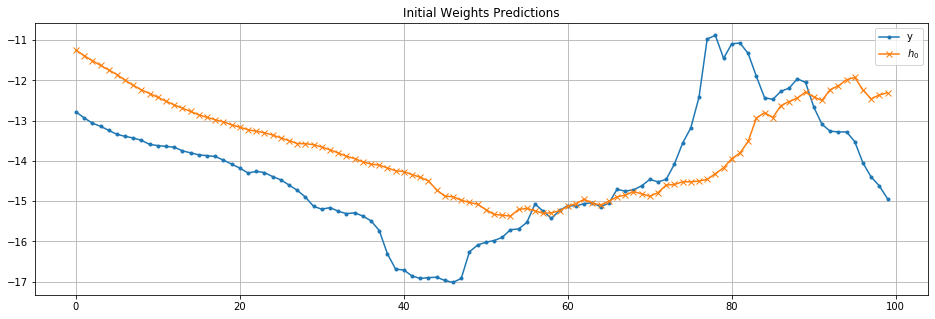

In [74]:
#Lets build a model with multiple features

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}


m = lstmmodel(32, (120,3), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1f = NNmodel(tsParams=tsParams, model=m, file="m3.h5")
nnmodel1f.prepare(dfn2, pct=80000)

y1, h1 = nnmodel1f.predict(nnmodel1f.df,0, 100)
o=Plot_(y1, h1, title="Initial Weights Predictions")


{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


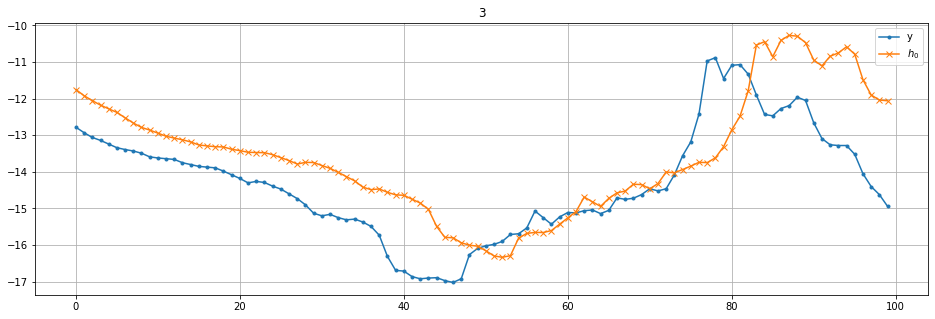

Epoch 1/1
200/200 [==============================] - 10s 52ms/step - loss: 0.0089 - val_loss: 0.0072


In [75]:
epochs= 4
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1f.predict(nnmodel1f.df,0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1f.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())
nnmodel1f.save()

# Compare the performance with one feature

{'inps': 32, 'inshape': (120, 1), 'units2': None, 'nsteps': 1, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (120, 1)}
Creating LSTM: inuts= 32 time-steps: 120, features: 1 #out: 1
#Training samples: 80000
{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


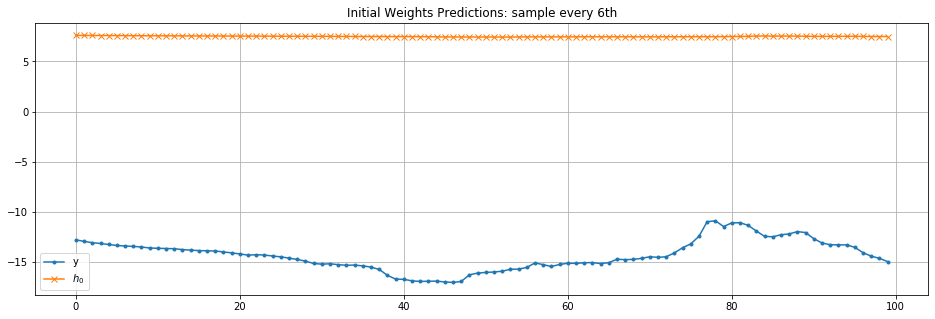

In [77]:
#Lets try sampling rate with one feature

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}

m = lstmmodel(32, (120,1), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1s = NNmodel(tsParams=tsParams, model=m, file="m3-1.h5")
nnmodel1s.prepare(dfn1, pct=80000)

y1, h1 = nnmodel1s.predict(nnmodel1s.df,0, 100)
o=Plot_(y1, h1, title="Initial Weights Predictions: sample every 6th")

{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


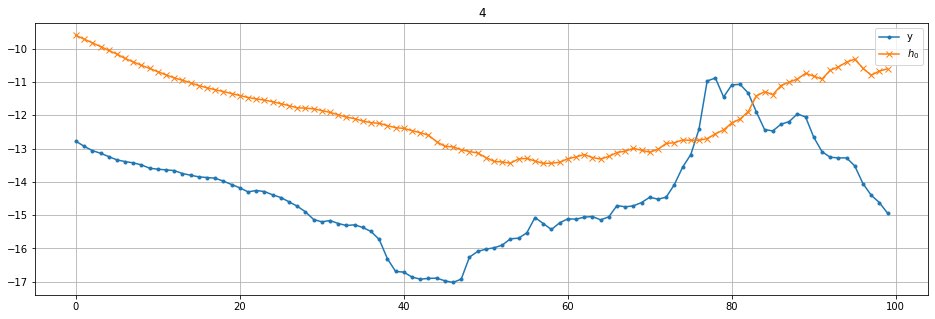

Epoch 1/1
200/200 [==============================] - 10s 52ms/step - loss: 0.0171 - val_loss: 0.0208


In [78]:
epochs=5
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1s.predict(nnmodel1s.df,0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1s.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1s.save()

{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


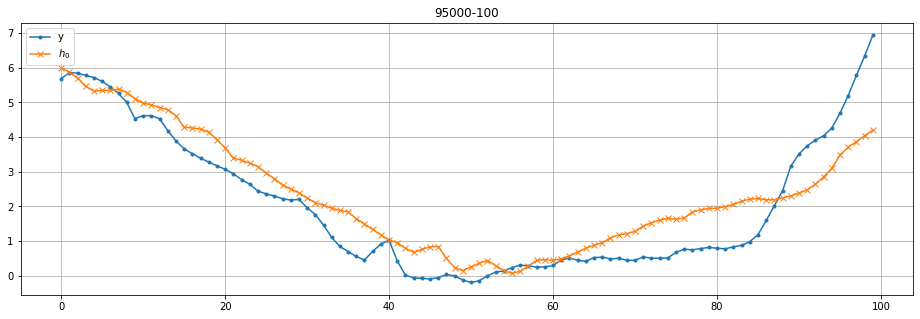

In [79]:
s,h = 95000, 100
y1, h1 = nnmodel1s.predict(nnmodel1s.df,s,h)
Plot_( y1, h1, title=f"{s}-{h}");

***
# MultiVariate Multiple Step Predictions

TimeseriesGenerator dont have mechanisms to generate multistep out, we need to prepare the data set as such.

In [80]:
#Example Uage of makesteps
a=list(range(10))
k=makestep(a, 5, 3)
a, k.shape, k

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], (3, 3), array([[5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]))

{'inps': 32, 'inshape': (120, 3), 'units2': 32, 'nsteps': 5, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (120, 3)}
Creating LSTM: inuts= 32 time-steps: 120, features: 3 #out: 5
#Training samples: 80000
{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


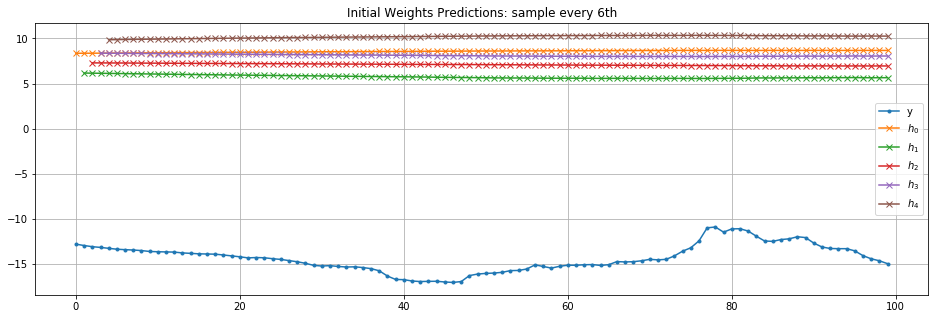

In [84]:
#Lets build a model with multiple features

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}

nsteps = 5 # 5 predictions

m = lstmmodel(32, (120,3), units2=32, nsteps=nsteps, opt="adam", loss="mse" )
nnmodel1mf = NNmodel(tsParams=tsParams, model=m, nsteps=nsteps, file="m3-step-5.h5")
nnmodel1mf.prepare(dfn2, pct=80000)

y1,h1 = nnmodel1mf.predict(nnmodel1mf.df,0, 100, scaleout=True)
#o=Plot_(y1, h1, title="Initial Weights Predictions-multistep")
o=Plot_(y1, h1, title="Initial Weights Predictions: sample every 6th")


{'length': 720, 'batch_size': 100, 'stride': 1, 'sampling_rate': 6}


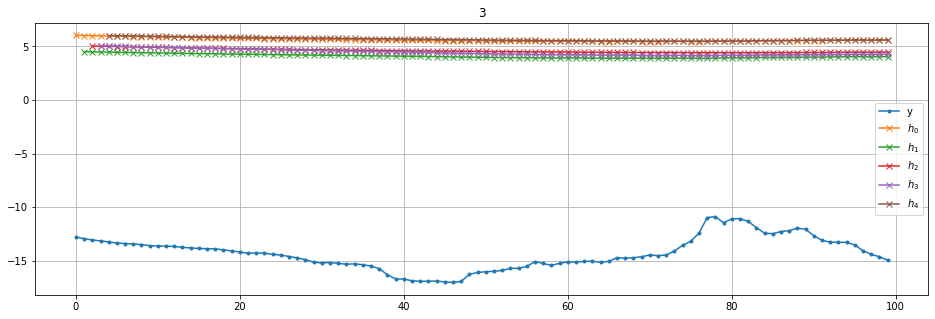

Epoch 1/1
200/200 [==============================] - 21s 104ms/step - loss: 0.4763 - val_loss: 0.3707


In [85]:
epochs=4
for i in range(epochs):
    plt.clf()  
    y1,h1 = nnmodel1mf.predict(nnmodel1mf.df,0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1mf.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1mf.save();

# Some explorations

In [ ]:
m=nnmodel1mf.model

keras.engine.sequential.Sequential.summary(m)

In [ ]:
m.get_input_shape_at(0), m.get_output_shape_at(0)
for i in range(len(m.layers)):
    l = m.layers[i]
    s = l.get_input_shape_at(0)
    o = l.get_output_shape_at(0)
    print(f'{i}=> inp shape: {str(s):15}, out shape: {o}')

l.get_output_shape_at(0)

In [ ]:
l=m.layers[0]

In [ ]:
for i in range(len(l.get_weights())):
    print(l.get_weights()[i].shape)

In [ ]:
3 *128 + 32 *128 + 128